# 第七章、聊天 Chat

 - [一、环境配置](#一、环境配置)
 - [二、记忆（Memory）](#二、记忆（Memory）)
 - [三、对话检索链（ConversationalRetrievalChain）](#三、对话检索链（ConversationalRetrievalChain）)
 - [四、创建一个适用于您文档的聊天机器人](#四、创建一个适用于您文档的聊天机器人)
 - [五、创建聊天机器人](#五、创建聊天机器人)
 - [六、致谢](#六、致谢)


回想一下检索增强生成 (retrieval augmented generation，RAG) 的整体工作流程：

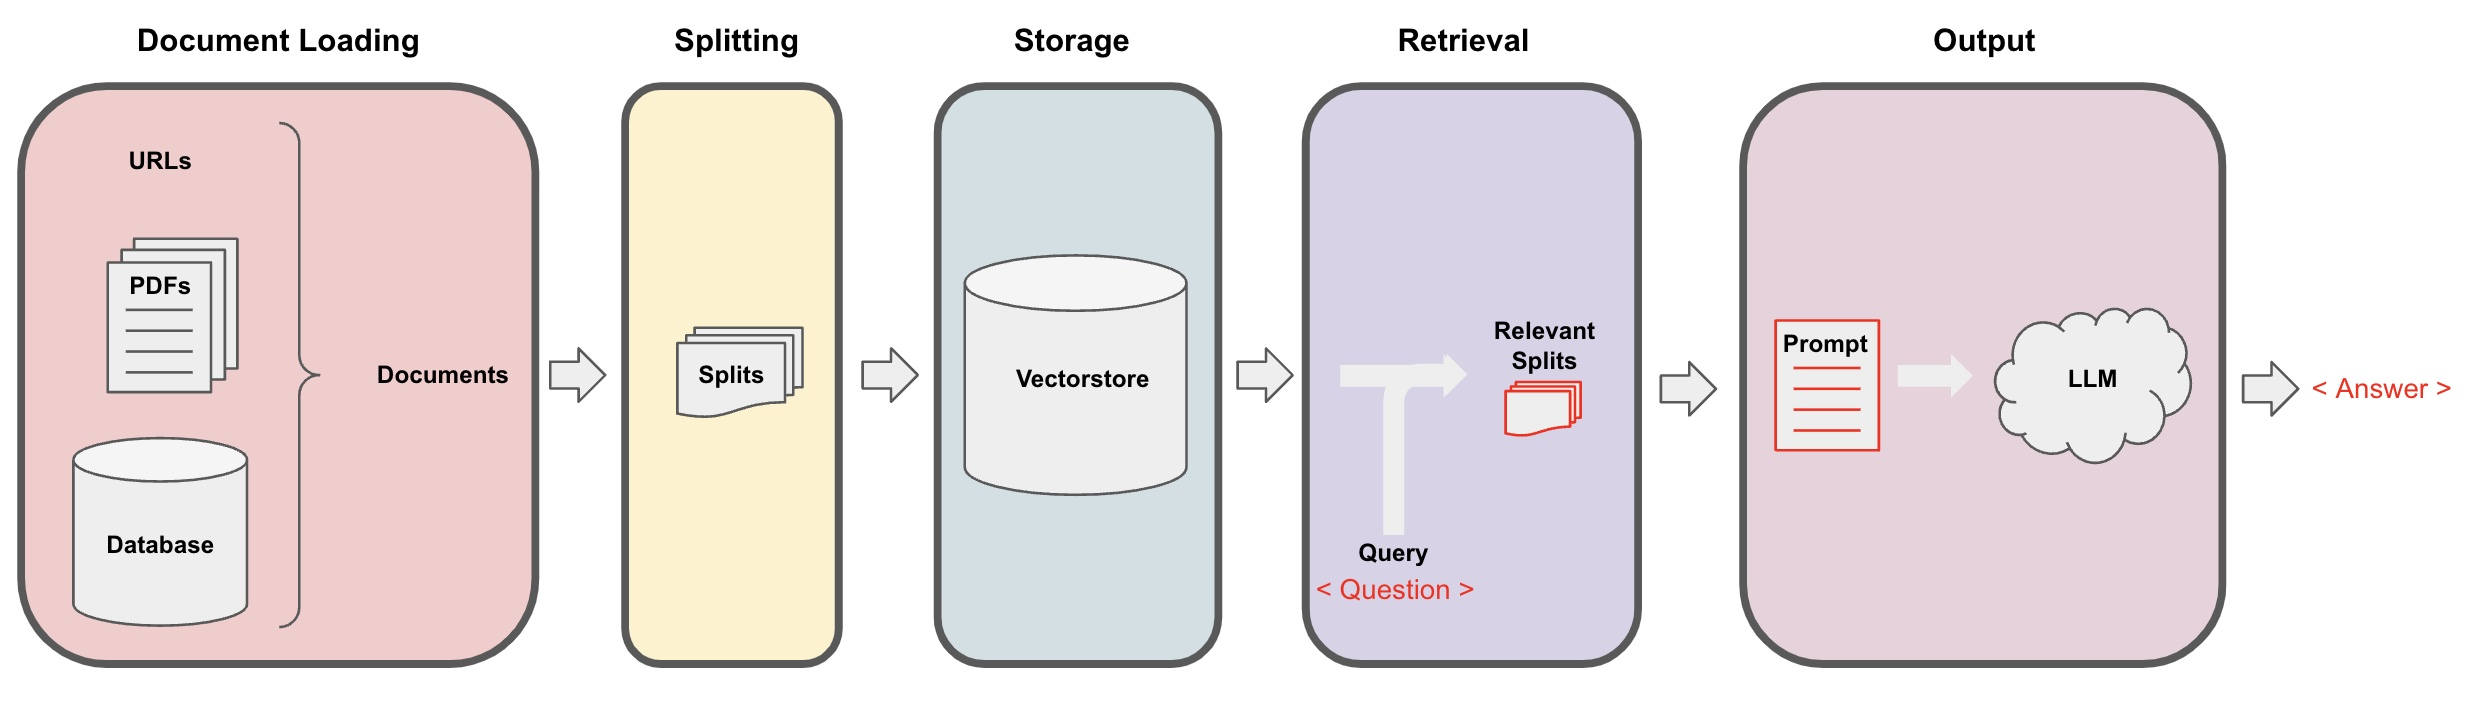

我们已经接近完成一个功能性的聊天机器人了。我们讨论了`文档加载`、`切分`、`存储`和`检索`。我们展示了如何使用`检索 QA`链在 Q+A 中使用`检索`生成输出。

我们的机器人已经可以回答问题了，但还无法处理后续问题，无法进行真正的对话。好消息是，在本章中，我们将解决这个问题。

我们现在将创建一个问答聊天机器人。它与之前非常相似，但我们将添加聊天历史的功能。这是您之前进行的任何对话或消息。这将使机器人在尝试回答问题时能够考虑到聊天历史的上下文。所以，如果您继续提问，它会知道您想谈论什么。

## 一、环境配置

In [ ]:
import os
import openai
import sys
sys.path.append('../..')

import panel as pn  # GUI
pn.extension()

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

openai.api_key  = os.environ['OPENAI_API_KEY']

以下代码是为了 openai LLM 版本备案，直至其被弃用（于 2023 年 9 月）。LLM 响应通常会有所不同，但在使用不同模型版本时，这种差异可能会更明显。

In [2]:
import datetime
current_date = datetime.datetime.now().date()
if current_date < datetime.date(2023, 9, 2):
    llm_name = "gpt-3.5-turbo-0301"
else:
    llm_name = "gpt-3.5-turbo"
print(llm_name)

gpt-3.5-turbo-0301


如果您想在 `Lang Chain plus` 平台上进行实验：

- 前往 langchain plus 平台并注册

- 从您的帐户设置创建 api 密钥

- 在下面的代码中使用此 api 密钥

In [ ]:
#import os
#os.environ["LANGCHAIN_TRACING_V2"] = "true"
#os.environ["LANGCHAIN_ENDPOINT"] = "https://api.langchain.plus"
#os.environ["LANGCHAIN_API_KEY"] = "..."

In [3]:
# 加载向量库，其中包含了所有课程材料的 Embedding。
from langchain.vectorstores import Chroma
from langchain.embeddings.openai import OpenAIEmbeddings
persist_directory = 'docs/chroma/'
embedding = OpenAIEmbeddings()
vectordb = Chroma(persist_directory=persist_directory, embedding_function=embedding)

In [5]:
# 对向量库进行基本的相似度搜索
question = "What are major topics for this class?"
docs = vectordb.similarity_search(question,k=3)
len(docs)

3

In [4]:
question = "这门课的主要内容是什么？"
docs = vectordb.similarity_search(question,k=3)
len(docs)

3

In [5]:
from langchain.chat_models import ChatOpenAI
llm = ChatOpenAI(model_name=llm_name, temperature=0)
llm.predict("Hello world!")

'Hello there! How can I assist you today?'

In [7]:
# 初始化一个 prompt 模板，创建一个检索 QA 链，然后传入一个问题并得到一个结果。
# 构建 prompt
from langchain.prompts import PromptTemplate
template = """Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer. Use three sentences maximum. Keep the answer as concise as possible. Always say "thanks for asking!" at the end of the answer. 
{context}
Question: {question}
Helpful Answer:"""
QA_CHAIN_PROMPT = PromptTemplate(input_variables=["context", "question"],template=template,)

# 运行 chain
from langchain.chains import RetrievalQA
question = "Is probability a class topic?"
qa_chain = RetrievalQA.from_chain_type(llm,
                                       retriever=vectordb.as_retriever(),
                                       return_source_documents=True,
                                       chain_type_kwargs={"prompt": QA_CHAIN_PROMPT})


result = qa_chain({"query": question})
result["result"]

'Yes, probability is assumed to be a prerequisite for this class. The instructor assumes familiarity with basic probability and statistics, and will go over some of the prerequisites in the discussion sections as a refresher course. Thanks for asking!'

In [6]:
# 构建 prompt
from langchain.prompts import PromptTemplate
template = """使用以下上下文来回答最后的问题。如果你不知道答案，就说你不知道，不要试图编造答案。最多使用三句话。尽量使答案简明扼要。总是在回答的最后说“谢谢你的提问！”。
{context}
问题: {question}
有用的回答:"""
QA_CHAIN_PROMPT = PromptTemplate(input_variables=["context", "question"],template=template,)

# 运行 chain
from langchain.chains import RetrievalQA
question = "概率是课堂主题吗？"
qa_chain = RetrievalQA.from_chain_type(llm,
                                       retriever=vectordb.as_retriever(),
                                       return_source_documents=True,
                                       chain_type_kwargs={"prompt": QA_CHAIN_PROMPT})


result = qa_chain({"query": question})
result["result"]

'概率是课堂主题之一，但这门课程不会过多涉及编程。需要对基本概率和统计学有一定的了解，以及基本的线性代数知识。谢谢你的提问！'

## 二、记忆（Memory）

现在让我们更进一步，添加一些记忆功能。

我们将使用 `ConversationBufferMemory`。它保存聊天消息历史记录的列表，这些历史记录将在回答问题时与问题一起传递给聊天机器人，从而将它们添加到上下文中。

需要注意的是，我们之前讨论的上下文检索等方法，在这里同样可用。 

In [7]:
from langchain.memory import ConversationBufferMemory
memory = ConversationBufferMemory(
    memory_key="chat_history", # 与 prompt 的输入变量保持一致。
    return_messages=True # 将以消息列表的形式返回聊天记录，而不是单个字符串
)

## 三、对话检索链（ConversationalRetrievalChain）

在检索 QA 链的基础上，对话检索链添加了新步骤，将历史记录和新问题压缩为一个独立的问题，并在向量库中进行相关文档的查找。此外，当有多个答案时，内存记录下所有答案。我们在运行和观察其效果后，可以在UI中查看具体细节。 

对话检索链（ConversationalRetrievalChain）在 QA 检索链的基础上增加了一个新的环节，而不仅仅是 memery。

具体来说，它增加了一个步骤，该步骤将历史记录和新问题浓缩为一个独立的问题，并将其传递给向量存储器以查找相关文档。


我们将在运行后在用户界面中查看其效果。但现在，让我们来试试。我们可以提出一个问题。这是没有任何历史记录的，看看我们得到的结果。然后我们可以针对答案提出一个后续问题。这和之前一样。所以我们问，概率是一个类主题吗？我们会得到一些答案。

In [8]:
from langchain.chains import ConversationalRetrievalChain
retriever=vectordb.as_retriever()
qa = ConversationalRetrievalChain.from_llm(
    llm,
    retriever=retriever,
    memory=memory
)

In [10]:
question = "Is probability a class topic?"
result = qa({"question": question})
print(result['answer'])

Yes, probability is a topic that will be assumed to be familiar to students in this class. The instructor assumes that students have a basic understanding of probability and statistics, and will go over some of the prerequisites as a refresher course in the discussion sections.


In [9]:
question = "概率是一个课堂主题吗？"
result = qa({"question": question})
print(result['answer'])

是的，根据文本中的描述，概率是这门课程的一个基本主题，因此学生需要对基本的概率和统计知识有所了解。


In [11]:
question = "why are those prerequesites needed?"
result = qa({"question": question})
print(result['answer'])

The reason for needing those prerequisites in the class is that the instructor assumes that all students have a basic knowledge of computer science and knowledge of the basic computer skills and principles, such as knowing what big-O notation is.


In [10]:
question = "为什么需要这些先决条件？"
result = qa({"question": question})
print(result['answer'])

学生需要对基本的概率和统计知识有所了解，因为这些知识是机器学习的基础。在机器学习中，我们需要使用概率和统计来理解和解决各种问题，例如分类、回归、聚类等。如果学生没有这些基础知识，将很难理解机器学习的概念和方法。此外，对于那些已经学过概率和统计的学生，这门课程将帮助他们将这些知识应用到机器学习中。


## 四、创建一个适用于您文档的聊天机器人

In [12]:
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.text_splitter import CharacterTextSplitter, RecursiveCharacterTextSplitter
from langchain.vectorstores import DocArrayInMemorySearch
from langchain.document_loaders import TextLoader
from langchain.chains import RetrievalQA,  ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory
from langchain.chat_models import ChatOpenAI
from langchain.document_loaders import TextLoader
from langchain.document_loaders import PyPDFLoader

跟视频拍摄相比，聊天机器人代码已进行了一些更新。图形用户界面的外观也因运行平台而异。

In [13]:
def load_db(file, chain_type, k):
    """
    该函数用于加载 PDF 文件，切分文档，生成文档的嵌入向量，创建向量数据库，定义检索器，并创建聊天机器人实例。

    参数:
    file (str): 要加载的 PDF 文件路径。
    chain_type (str): 链类型，用于指定聊天机器人的类型。
    k (int): 在检索过程中，返回最相似的 k 个结果。

    返回:
    qa (ConversationalRetrievalChain): 创建的聊天机器人实例。
    """
    # 载入文档
    loader = PyPDFLoader(file)
    documents = loader.load()
    # 切分文档
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=150)
    docs = text_splitter.split_documents(documents)
    # 定义 Embeddings
    embeddings = OpenAIEmbeddings()
    # 根据数据创建向量数据库
    db = DocArrayInMemorySearch.from_documents(docs, embeddings)
    # 定义检索器
    retriever = db.as_retriever(search_type="similarity", search_kwargs={"k": k})
    # 创建 chatbot 链，Memory 由外部管理
    qa = ConversationalRetrievalChain.from_llm(
        llm=ChatOpenAI(model_name=llm_name, temperature=0), 
        chain_type=chain_type, 
        retriever=retriever, 
        return_source_documents=True,
        return_generated_question=True,
    )
    return qa 


In [14]:
import panel as pn
import param

# 用于存储聊天记录、回答、数据库查询和回复
class cbfs(param.Parameterized):
    chat_history = param.List([])
    answer = param.String("")
    db_query  = param.String("")
    db_response = param.List([])
    
    def __init__(self,  **params):
        super(cbfs, self).__init__( **params)
        self.panels = []
        self.loaded_file = "docs/cs229_lectures/MachineLearning-Lecture01.pdf"
        self.qa = load_db(self.loaded_file,"stuff", 4)
    
    # 将文档加载到聊天机器人中
    def call_load_db(self, count):
        """
        count: 数量
        """
        if count == 0 or file_input.value is None:  # 初始化或未指定文件 :
            return pn.pane.Markdown(f"Loaded File: {self.loaded_file}")
        else:
            file_input.save("temp.pdf")  # 本地副本
            self.loaded_file = file_input.filename
            button_load.button_style="outline"
            self.qa = load_db("temp.pdf", "stuff", 4)
            button_load.button_style="solid"
        self.clr_history()
        return pn.pane.Markdown(f"Loaded File: {self.loaded_file}")

    # 处理对话链
    def convchain(self, query):
        """
        query: 用户的查询
        """
        if not query:
            return pn.WidgetBox(pn.Row('User:', pn.pane.Markdown("", width=600)), scroll=True)
        result = self.qa({"question": query, "chat_history": self.chat_history})
        self.chat_history.extend([(query, result["answer"])])
        self.db_query = result["generated_question"]
        self.db_response = result["source_documents"]
        self.answer = result['answer'] 
        self.panels.extend([
            pn.Row('User:', pn.pane.Markdown(query, width=600)),
            pn.Row('ChatBot:', pn.pane.Markdown(self.answer, width=600, style={'background-color': '#F6F6F6'}))
        ])
        inp.value = ''  # 清除时清除装载指示器
        return pn.WidgetBox(*self.panels,scroll=True)
    
    # 获取最后发送到数据库的问题
    @param.depends('db_query ', )
    def get_lquest(self):
        if not self.db_query :
            return pn.Column(
                pn.Row(pn.pane.Markdown(f"Last question to DB:", styles={'background-color': '#F6F6F6'})),
                pn.Row(pn.pane.Str("no DB accesses so far"))
            )
        return pn.Column(
            pn.Row(pn.pane.Markdown(f"DB query:", styles={'background-color': '#F6F6F6'})),
            pn.pane.Str(self.db_query )
        )
    
    # 获取数据库返回的源文件
    @param.depends('db_response', )
    def get_sources(self):
        if not self.db_response:
            return 
        rlist=[pn.Row(pn.pane.Markdown(f"Result of DB lookup:", styles={'background-color': '#F6F6F6'}))]
        for doc in self.db_response:
            rlist.append(pn.Row(pn.pane.Str(doc)))
        return pn.WidgetBox(*rlist, width=600, scroll=True)

    # 获取当前聊天记录
    @param.depends('convchain', 'clr_history') 
    def get_chats(self):
        if not self.chat_history:
            return pn.WidgetBox(pn.Row(pn.pane.Str("No History Yet")), width=600, scroll=True)
        rlist=[pn.Row(pn.pane.Markdown(f"Current Chat History variable", styles={'background-color': '#F6F6F6'}))]
        for exchange in self.chat_history:
            rlist.append(pn.Row(pn.pane.Str(exchange)))
        return pn.WidgetBox(*rlist, width=600, scroll=True)
    
    # 清除聊天记录
    def clr_history(self,count=0):
        self.chat_history = []
        return 


## 五、创建聊天机器人

Column
    [0] Row
        [0] Markdown(str)
    [1] Tabs
        [0] Column
            [0] Row
                [0] TextInput(placeholder='Enter text here…')
            [1] Divider()
            [2] ParamFunction(function, _pane=WidgetBox, defer_load=False, height=300, loading_indicator=True)
            [3] Divider()
        [1] Column
            [0] ParamMethod(method, _pane=Column, defer_load=False)
            [1] Divider()
            [2] ParamMethod(method, _pane=Str, defer_load=False)
        [2] Column
            [0] ParamMethod(method, _pane=WidgetBox, defer_load=False)
            [1] Divider()
        [3] Column
            [0] Row
                [0] FileInput(accept='.pdf')
                [1] Button(button_type='primary', name='Load DB')
                [2] ParamFunction(function, _pane=Markdown, defer_load=False)
            [1] Row
                [0] Button(button_type='warning', name='Clear History')
                [1] Markdown(str)
            [2] Divider()
            [3] Row
                [0] Image(str, width=400)
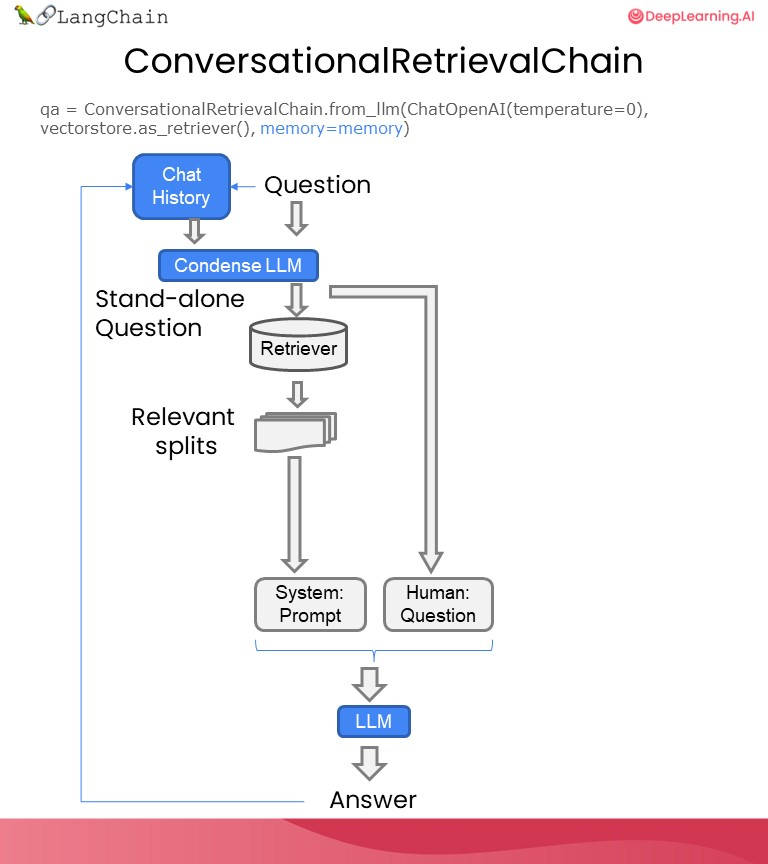

In [15]:
# 初始化聊天机器人
cb = cbfs() 

# 定义界面的小部件
file_input = pn.widgets.FileInput(accept='.pdf') # PDF 文件的文件输入小部件
button_load = pn.widgets.Button(name="Load DB", button_type='primary') # 加载数据库的按钮
button_clearhistory = pn.widgets.Button(name="Clear History", button_type='warning') # 清除聊天记录的按钮
button_clearhistory.on_click(cb.clr_history) # 将清除历史记录功能绑定到按钮上
inp = pn.widgets.TextInput( placeholder='Enter text here…') # 用于用户查询的文本输入小部件

# 将加载数据库和对话的函数绑定到相应的部件上
bound_button_load = pn.bind(cb.call_load_db, button_load.param.clicks)
conversation = pn.bind(cb.convchain, inp) 

jpg_pane = pn.pane.Image( './img/convchain.jpg')

# 使用 Panel 定义界面布局
tab1 = pn.Column(
    pn.Row(inp),
    pn.layout.Divider(),
    pn.panel(conversation,  loading_indicator=True, height=300),
    pn.layout.Divider(),
)
tab2= pn.Column(
    pn.panel(cb.get_lquest),
    pn.layout.Divider(),
    pn.panel(cb.get_sources ),
)
tab3= pn.Column(
    pn.panel(cb.get_chats),
    pn.layout.Divider(),
)
tab4=pn.Column(
    pn.Row( file_input, button_load, bound_button_load),
    pn.Row( button_clearhistory, pn.pane.Markdown("Clears chat history. Can use to start a new topic" )),
    pn.layout.Divider(),
    pn.Row(jpg_pane.clone(width=400))
)
# 将所有选项卡合并为一个仪表盘
dashboard = pn.Column(
    pn.Row(pn.pane.Markdown('# ChatWithYourData_Bot')),
    pn.Tabs(('Conversation', tab1), ('Database', tab2), ('Chat History', tab3),('Configure', tab4))
)
dashboard

请随意复制此代码并对其进行修改以添加您自己的功能。您可以通过更改 `load_db` 函数和 `convchain` 方法中的配置来尝试备用内存和检索器模型。[panel](https://panel.holoviz.org/) 和 [Param](https://param.holoviz.org/) 有许多有用的特性和小部件，可以用来扩展GUI。

## 六、致谢

基于 panel 的聊天机器人的灵感来自 Sophia Yang, [github](https://github.com/sophiamyang/tutorials-LangChain)